In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import DataLoader
from typing import List, Callable

Neural differential solver functionality:

In [16]:
class DNN(nn.Module):
    def __init__(self, input_shape: int, hidden_shapes: List[int], output_shape: int, activations: List[Callable] = None):
        super(DNN, self).__init__()
        depth = len(hidden_shapes)
        if activations is None:
            activations = [nn.Sigmoid() for _ in range(depth)]  # sigmoid as default
        else:
            assert len(activations) == depth
        layers = []
        layers.append(nn.Linear(input_shape, hidden_shapes[0]))
        layers.append(activations[0])
        for layer_i in range(1, depth):
            layers.append(nn.Linear(hidden_shapes[layer_i-1], hidden_shapes[layer_i]))
            layers.append(activations[layer_i])
        layers.append(nn.Linear(hidden_shapes[-1], output_shape))
        self.model = nn.Sequential(*layers)  # unpack list by `*list`

    def forward(self, x: torch.Tensor):
        return self.model(x)


def calcGradients(function, x, order):
    y = function(x)
    f_primes = torch.ones_like(x)
    for order_i in range(order):
        # Possibly you could create graph only for order_i+1 < order
        f_primes = torch.autograd.grad(outputs=y, inputs=x, grad_outputs=f_primes, create_graph=True, retain_graph=True)[0]
        y = f_primes
    return f_primes


class LossFunction(nn.Module):
    def __init__(self, differential_expressions: List[Callable], bc_grad_orders: List[int], 
                 bc_functions: list[Callable], bc_boundaries: List[float], ):
        super(LossFunction, self).__init__()
        self.differential_expressions = differential_expressions
        self.problem_order = len(bc_boundaries)
        self.bc_grad_orders = bc_grad_orders
        self.bc_functions = bc_functions
        self.bc_boundaries = [None for _ in range(self.problem_order)]
        for i, b in enumerate(bc_boundaries):
            self.bc_boundaries[i] = torch.tensor([float(b)], requires_grad=True)
        assert self.problem_order == len(self.bc_grad_orders) and self.problem_order == len(self.bc_functions)
    
    def _calcBoundaryCondition(self, model: nn.Module, bc_indices: List[int]):
        bc_term = 0.0
        for bc_i in bc_indices:
            term1 = calcGradients(model, self.bc_boundaries[bc_i], self.bc_grad_orders[bc_i])  # grad_x^p_i model(x_{b_i})
            term2 = self.bc_functions[bc_i](self.bc_boundaries[bc_i])  # K_i(x_{p_i})
            bc_term += (term1 - term2)**2
        return bc_term

    def __call__(self, model: nn.Module, x_data: torch.Tensor, include_all_bc: bool = False):
        x_max = x_data.shape[0]
        F_term = self.differential_expressions(model, x_data).square().sum() / x_max
        if include_all_bc:
            bc_indices = [i for i in range(self.problem_order)]
        else:
            bc_indices = []
            for bc_i, bc_boundary in enumerate(self.bc_boundaries):
                if torch.isin(bc_boundary, x_data).any(): bc_indices.append(bc_i)
        bc_term = self._calcBoundaryCondition(model, bc_indices)
        print("F_term", F_term)
        print("bc_term", bc_term)
        return F_term + bc_term


def training(model, loss_fn, dataloader, num_epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_history = []

    model.train()  # Make sure to be in train mode
    for epoch_i in range(num_epochs):
        running_loss = 0.0
        for batch_i, batch_x in enumerate(dataloader):
            # Input data in appropriate shape
            batch_x = batch_x.unsqueeze(-1)
            # NB no need to specifically calculate forward push
            # Backpropagation
            optimizer.zero_grad()
            loss = loss_fn(model, batch_x)
            loss.backward()
            optimizer.step()
            # Keep track of loss
            running_loss += loss.item()
        
        loss_history.append(running_loss)
        # Print progress
        print("Epoch {}/{} Loss: {:.4f}". format(epoch_i+1, num_epochs, running_loss))

    return loss_history

        

Example 1: Solve $f'(x) - x - 1 = 0$ with boundary condition $f(0) = 0$ on $x \in [0,\infty]$. Analytic solution is $f(x) = x^2 / 2 + x + c$ where now $c = 0$.

In [17]:
# --- Problem definitions ---
def equation_1(f, x):
    f_prime = calcGradients(f, x, 1)
    return f_prime - x - 1

def bc_function_1(x):
    return 0.0

bc_functions = [bc_function_1]
bc_ps = [0]
bc_xs = [0.0]

x_min = 0.0
x_max = 1.0


# --- Solver input definitions ---
# Loss
loss_fn = LossFunction(equation_1, bc_ps, bc_functions, bc_xs)

# Domain specification
discretization = 0.01
batch_size = 100
batch_shuffle = True

x = np.arange(x_min, x_max, discretization)
x_tensor = torch.from_numpy(x).float().requires_grad_(True)
dataloader = DataLoader(x_tensor, batch_size=batch_size, shuffle=batch_shuffle)

# Model
hidden_shapes = [100, 100]
input_shape = 1
output_shape = 1
model = DNN(input_shape, hidden_shapes, output_shape)

# Training
num_epochs = 100
learning_rate = 0.01


F_term tensor(2.3287, grad_fn=<DivBackward0>)
bc_term tensor([1.])
Epoch 1/100 Loss: 3.3287
F_term tensor(1.8869, grad_fn=<DivBackward0>)
bc_term tensor([1.])
Epoch 2/100 Loss: 2.8869
F_term tensor(1.4414, grad_fn=<DivBackward0>)
bc_term tensor([1.])
Epoch 3/100 Loss: 2.4414
F_term tensor(0.9754, grad_fn=<DivBackward0>)
bc_term tensor([1.])
Epoch 4/100 Loss: 1.9754
F_term tensor(0.5382, grad_fn=<DivBackward0>)
bc_term tensor([1.])
Epoch 5/100 Loss: 1.5382
F_term tensor(0.2176, grad_fn=<DivBackward0>)
bc_term tensor([1.])
Epoch 6/100 Loss: 1.2176
F_term tensor(0.1227, grad_fn=<DivBackward0>)
bc_term tensor([1.])
Epoch 7/100 Loss: 1.1227
F_term tensor(0.2948, grad_fn=<DivBackward0>)
bc_term tensor([1.])
Epoch 8/100 Loss: 1.2947
F_term tensor(0.5053, grad_fn=<DivBackward0>)
bc_term tensor([1.])
Epoch 9/100 Loss: 1.5053
F_term tensor(0.5203, grad_fn=<DivBackward0>)
bc_term tensor([1.])
Epoch 10/100 Loss: 1.5203
F_term tensor(0.3713, grad_fn=<DivBackward0>)
bc_term tensor([1.])
Epoch 11/100

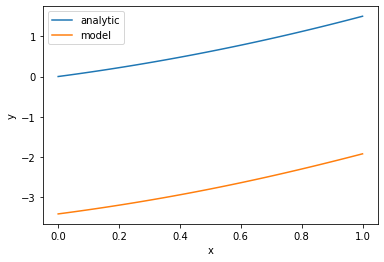

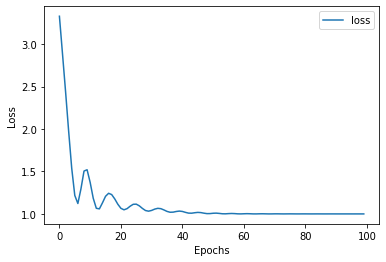

In [18]:
# --- Running solver ---
loss_data = training(model, loss_fn, dataloader, num_epochs, learning_rate)

# --- Result visualization
def equation_1_analytic(x):
    return x**2 * 0.5 + x

model.eval()
x_eval = np.linspace(0,1,100)
y_analytic = equation_1_analytic(x_eval)
x_eval_tensor = torch.from_numpy(x_eval).float().unsqueeze(-1)
y_model = model(x_eval_tensor).detach().flatten().numpy()

plt.plot(x_eval, y_analytic, label="analytic")
plt.plot(x_eval, y_model, label="model")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

plt.plot(loss_data, label="loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()